In [1]:
import collections
import copy
import pickle
import os
import tempfile
import pathlib
import urllib

import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform, pdist, cdist

from skmatter.preprocessing import StandardFlexibleScaler, KernelNormalizer
from skmatter.metrics import global_reconstruction_error

from rascal.representations import SphericalInvariants, SphericalExpansion
from rascal.utils import get_optimal_radial_basis_hypers

import ase
import ase.io

In [2]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

mpl.rc('font', family='sans-serif')
mpl.rc('font', serif='Helvetica')
mpl.rc('font', size=15)

mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.major.size'] = 3

mpl.rcParams['ytick.direction'] = 'out'
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.major.size'] = 3

mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['ytick.labelsize'] = 13

mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['axes.linewidth'] = 1
mpl.rcParams['axes.labelsize'] = 2
mpl.rcParams['legend.fontsize'] = 18
mpl.rcParams['axes.titlesize'] = 27

mpl.rcParams['axes.titlesize'] = 15
mpl.rcParams["axes.labelsize"] = 15

In [3]:

# Set RESULT_DIR if you want to save intermedial resutls permantly somwehere
# to run calculations faster next time
RESULT_DIR = "./"
if RESULT_DIR is None:
    TMP_DIR = tempfile.TemporaryDirectory()
    RESULT_DIR = TMP_DIR.name

In [4]:
def nested_dict():
    return collections.defaultdict(nested_dict)

In [5]:
url = "https://archive.materialscloud.org/record/file?filename=dataset.xyz&record_id=45"
urllib.request.urlretrieve(url, os.path.join(os.getcwd(),'ice.xyz'))

('/home/goscinsk/code/skmatter-ore/paper/ice.xyz',
 <http.client.HTTPMessage at 0x7fe7285c2ca0>)

In [6]:
# strip apostroph
with open('ice.xyz', 'r') as f:
    content = f.read()

stripped_content = content.replace("'L", "L").replace(":3'", ":3")

with open('ice.xyz', 'w') as f:
    f.write(stripped_content)


In [7]:
stride = 1
frames = ase.io.read('ice.xyz', f'::{stride}')


In [8]:
print(len(frames))
print(sum([len(frame) for frame in frames]))
dists_HH = []
dists_HO = []
dists_OO = []
dists_OH = []
interaction_cutoff = 5
nb_atoms_H = []
nb_atoms_O = []
volumes = []
const_replica = 14 # I increased this until number of distances converged
for frame in frames:
    frame.wrap(eps=1e-12)
    dist = [0]*3
    # used to estimate the maximum number of repetitions needed
    # but it was not enough so I just increased the number of replicas by a constant until convergence
    for i in range(3):
        dist[i] = frame.get_volume()/np.linalg.norm(np.cross(frame.cell[(i + 1) % 3], frame.cell[(i + 2) % 3]))

    scell = frame.repeat([int(np.ceil(const_replica*interaction_cutoff/dist[0])), int(np.ceil(const_replica*interaction_cutoff/dist[1])),
                          int(np.ceil(const_replica*interaction_cutoff/dist[2]))])
    distm = cdist(frame.positions, scell.positions)
    idx_H = np.where(frame.numbers == 1)[0]
    idx_H_scell = np.where(scell.numbers == 1)[0]
    idx_O = np.where(frame.numbers == 8)[0]
    idx_O_scell = np.where(scell.numbers == 8)[0]    
    
    nb_atoms_H.append( len(idx_H) )
    nb_atoms_O.append( len(idx_O) )
    volumes.append( scell.get_volume() )
    
    distsHH = distm[idx_H][:, idx_H_scell].flatten()
    distsHH = distsHH[distsHH < interaction_cutoff]
    distsHH = distsHH[distsHH > 0]
    distsHO = distm[idx_H][:, idx_O_scell].flatten()
    distsHO = distsHO[distsHO < interaction_cutoff]
    distsHO = distsHO[distsHO > 0]    
    distsOO = distm[idx_O][:, idx_O_scell].flatten()
    distsOO = distsOO[distsOO < interaction_cutoff]
    distsOO = distsOO[distsOO > 0]
    distsOH = distm[idx_O][:, idx_H_scell].flatten()
    distsOH = distsOH[distsOH < interaction_cutoff]
    distsOH = distsOH[distsOH > 0]
    
    dists_HH.extend( distsHH.tolist() )
    dists_HO.extend( distsHO.tolist() )
    dists_OO.extend( distsOO.tolist() )
    dists_OH.extend( distsOH.tolist() )
    

dists_HH = np.array(dists_HH)
dists_HO = np.array(dists_HO)
dists_OO = np.array(dists_OO)
dists_OH = np.array(dists_OH)

print()
print(len(dists_HH))
print(len(dists_HO))
print(len(dists_OH))
print(len(dists_OO))

15869
673392

13228057
6812206
6815219
3175109


In [9]:
def binidx(x, bins):
    return np.argmin(cdist(x.reshape(-1,1), bins.reshape(-1,1)), axis=1)
def volsphere(r):
    return 4/3*np.pi*r**3

def sphere_norm(r, deltar):
    # assumes equispaced grid
    return 4*np.pi*deltar*r**2


OH


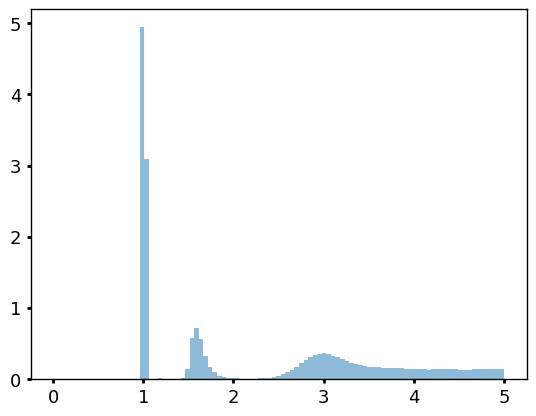

HO


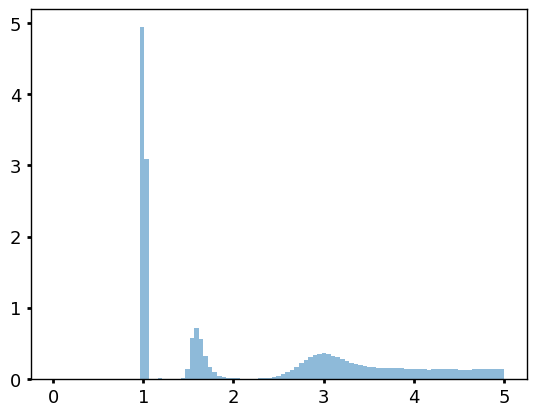

In [10]:
radial_grid = np.linspace(0, interaction_cutoff, 100)

bins_vol = volsphere(radial_grid[1:]) - volsphere(radial_grid[:-1])
bins_vol = np.hstack([0, bins_vol])


dists_OH_cut = dists_OH[dists_OH < interaction_cutoff]
dists_OH_weights = 1/bins_vol[binidx(dists_OH_cut, radial_grid)]
bincounts_OH = plt.hist(dists_OH_cut, bins=radial_grid, label='OH', alpha=0.5, weights=dists_OH_weights, density=True)[0]
print('OH')
plt.show()

dists_HO_cut = dists_HO[dists_HO < interaction_cutoff]
dists_HO_weights = 1/bins_vol[binidx(dists_HO_cut, radial_grid)]
bincounts_HO = plt.hist(dists_HO_cut, bins=radial_grid, label='HO', alpha=0.5, weights=dists_HO_weights, density=True)[0]
print('HO')
plt.show()

HH
OO
OH


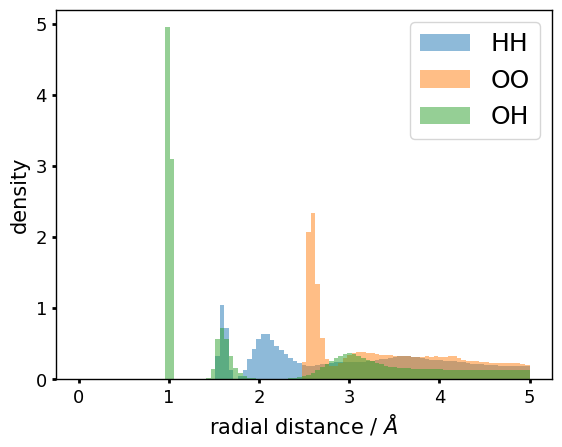

In [11]:
radial_grid = np.linspace(0, interaction_cutoff, 100)

bins_vol = volsphere(radial_grid[1:]) - volsphere(radial_grid[:-1])
bins_vol = np.hstack([0, bins_vol])

dists_HH_cut = dists_HH[dists_HH < interaction_cutoff]
dists_HH_weights = 1/bins_vol[binidx(dists_HH_cut, radial_grid)]
bincounts_HH = plt.hist(dists_HH_cut, bins=radial_grid, label='HH', alpha=0.5, weights=dists_HH_weights, density=True)[0]
print('HH')

dists_OO_cut = dists_OO[dists_OO < interaction_cutoff]
dists_OO_weights = 1/bins_vol[binidx(dists_OO_cut, radial_grid)]
bincounts_OO = plt.hist(dists_OO_cut, bins=radial_grid, label='OO', alpha=0.5, weights=dists_OO_weights, density=True)[0]
print('OO')

dists_OH_cut = dists_OH[dists_OH < interaction_cutoff]
dists_OH_weights = 1/bins_vol[binidx(dists_OH_cut, radial_grid)]
bincounts_OH = plt.hist(dists_OH_cut, bins=radial_grid, label='OH', alpha=0.5, weights=dists_OH_weights, density=True)[0]
print('OH')

plt.legend()
plt.xticks(np.arange(interaction_cutoff+1))
plt.ylabel('density')
plt.xlabel('radial distance / $\AA$')
plt.savefig('rdf_weighted.svg')
plt.savefig('rdf_weighted.png')
plt.show()

peaks HH [1.56565657 2.07070707 3.58585859]


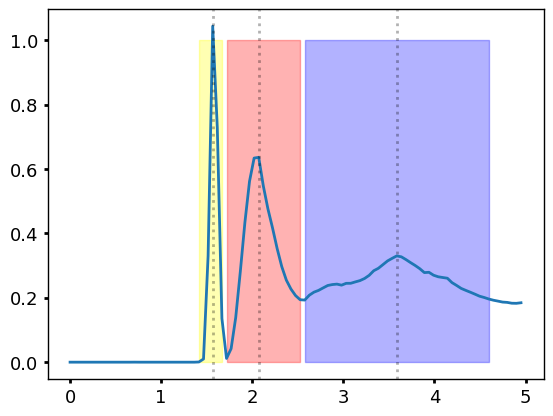

In [12]:
peak1_HH_idx = np.where(np.logical_and(radial_grid > 1, radial_grid < 2))[0]
peak1_HH_id = np.argmax(bincounts_HH[peak1_HH_idx])
peak1_HH = radial_grid[peak1_HH_idx][peak1_HH_id]
#peak1_HH_prob = bincounts_HH[np.linalg.norm(bincounts_HH - peak1_HH)]

peak2_HH_idx = np.where(np.logical_and(radial_grid > 2, radial_grid < 3))[0]
peak2_HH_id = np.argmax(bincounts_HH[peak2_HH_idx])
peak2_HH = radial_grid[peak2_HH_idx][peak2_HH_id]

peak3_HH_idx = np.where(np.logical_and(radial_grid > 3, radial_grid < 4))[0]
peak3_HH_id = np.argmax(bincounts_HH[peak3_HH_idx])
peak3_HH = radial_grid[peak3_HH_idx][peak3_HH_id]

peaks_HH_idx = [peak1_HH_idx, peak2_HH_idx, peak3_HH_idx]
peaks_HH_id = np.array([peak1_HH_id, peak2_HH_id, peak3_HH_id])
peaks_HH = np.array([peak1_HH, peak2_HH, peak3_HH])
print("peaks HH", peaks_HH)


rings_range_HH = [(1.35,1.68),(1.68,2.56),(2.56,4.61)]
rings_width_HH = [(1.4,1.68),(1.68,2.56),(2.56,4.61)]
colors = ['yellow', 'red', 'blue']

plt.plot(radial_grid[:-1], bincounts_HH)
for i in range(len(peaks_HH)):
    plt.axvline(peaks_HH[i], color='black', alpha=0.3, linestyle='dotted')
    range_idx = np.where(np.logical_and(
        radial_grid[:-1] > rings_width_HH[i][0],
        radial_grid[:-1] < rings_width_HH[i][1]))[0]

    plt.fill_between(radial_grid[range_idx], 0, 1, color=colors[i], alpha=0.3)
    #pdf = scipy.stats.norm.pdf(radial_grid, loc=peaks_HH[i] , scale=)
    #pdf *= peaks_HH[i]

peaks OO [2.57575758]


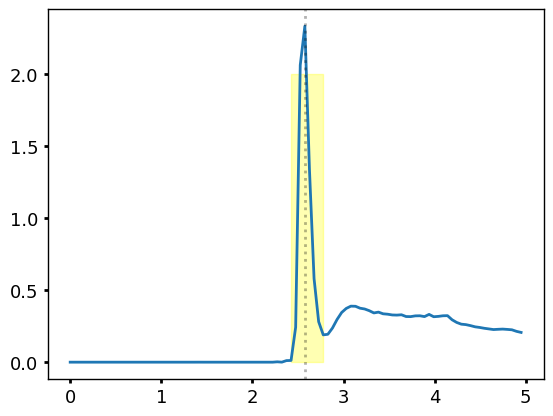

In [13]:
idx = np.where(np.logical_and(radial_grid > 2, radial_grid < 3))[0]
peak1_OO = radial_grid[idx][np.argmax(bincounts_OO[idx])]
peaks_OO = np.array([peak1_OO])
print("peaks OO", peaks_OO)

rings_range_OO = [(2.4,2.79)]
rings_width_OO = [(2.4,2.79)]
colors = ['yellow', 'red', 'blue']

plt.plot(radial_grid[:-1], bincounts_OO)
for i in range(len(peaks_OO)):
    plt.axvline(peaks_OO[i], color='black', alpha=0.3, linestyle='dotted')
    range_idx = np.where(np.logical_and(
        radial_grid[:-1] > rings_width_OO[i][0],
        radial_grid[:-1] < rings_width_OO[i][1]))[0]

    plt.fill_between(radial_grid[range_idx], 0, 2, color=colors[i], alpha=0.3)

peaks OH [0.95959596 1.56565657 2.97979798]


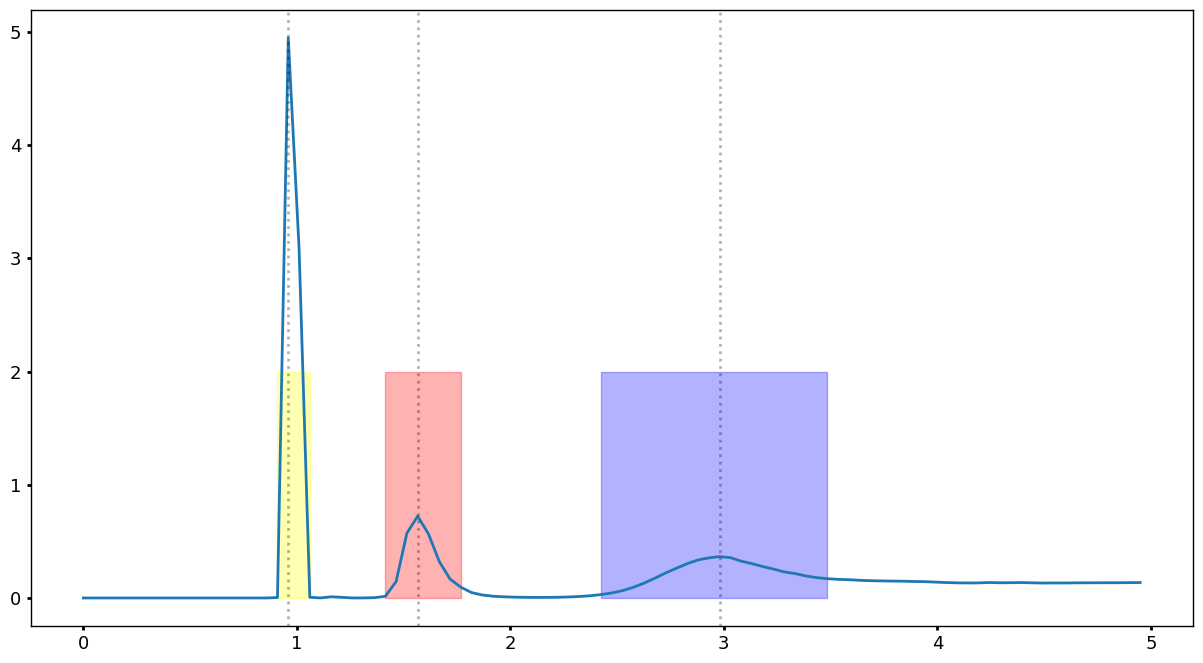

In [14]:
idx = np.where(np.logical_and(radial_grid > 0.5, radial_grid < 1.5))[0]
peak1_OH = radial_grid[idx][np.argmax(bincounts_OH[idx])]

idx = np.where(np.logical_and(radial_grid > 1.5, radial_grid < 2.5))[0]
peak2_OH = radial_grid[idx][np.argmax(bincounts_OH[idx])]

idx = np.where(np.logical_and(radial_grid > 2.5, radial_grid < 3.5))[0]
peak3_OH = radial_grid[idx][np.argmax(bincounts_OH[idx])]
peaks_OH = np.array([peak1_OH, peak2_OH, peak3_OH])

print("peaks OH", peaks_OH)
rings_range_OH = [(0.8,1.2),(1.2,2),(2.4,3.5)]
rings_width_OH = [(0.9,1.1),(1.4,1.8),(2.4,3.5)]
colors = ['yellow', 'red', 'blue']

plt.figure(figsize=(15,8))
plt.plot(radial_grid[:-1], bincounts_OH)
for i in range(len(peaks_OH)):
    plt.axvline(peaks_OH[i], color='black', alpha=0.3, linestyle='dotted')
    range_idx = np.where(np.logical_and(
        radial_grid[:-1] > rings_width_OH[i][0],
        radial_grid[:-1] < rings_width_OH[i][1]))[0]

    plt.fill_between(radial_grid[range_idx], 0, 2, color=colors[i], alpha=0.3)

peaks HO [1.01010101 2.97979798 3.03030303]


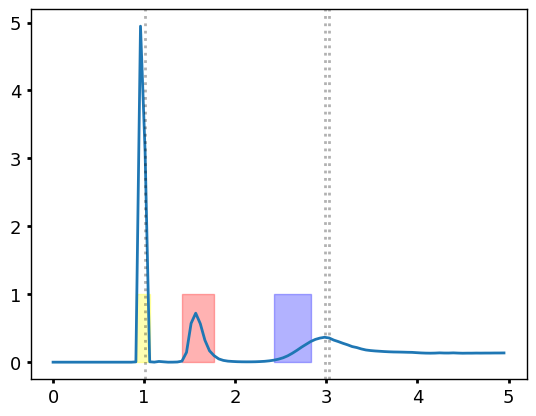

In [15]:
peak1_HO_idx = np.where(np.logical_and(radial_grid > 1, radial_grid < 2))[0]
peak1_HO_id = np.argmax(bincounts_HO[peak1_HO_idx])
peak1_HO = radial_grid[peak1_HO_idx][peak1_HO_id]
#peak1_HO_prob = bincounts_HO[np.linalg.norm(bincounts_HO - peak1_HO)]

peak2_HO_idx = np.where(np.logical_and(radial_grid > 2, radial_grid < 3))[0]
peak2_HO_id = np.argmax(bincounts_HO[peak2_HO_idx])
peak2_HO = radial_grid[peak2_HO_idx][peak2_HO_id]

peak3_HO_idx = np.where(np.logical_and(radial_grid > 3, radial_grid < 4))[0]
peak3_HO_id = np.argmax(bincounts_HO[peak3_HO_idx])
peak3_HO = radial_grid[peak3_HO_idx][peak3_HO_id]

peaks_HO_idx = [peak1_HO_idx, peak2_HO_idx, peak3_HO_idx]
peaks_HO_id = np.array([peak1_HO_id, peak2_HO_id, peak3_HO_id])
peaks_HO = np.array([peak1_HO, peak2_HO, peak3_HO])
print("peaks HO", peaks_HO)


rings_range_HO = [(0.8,1.2),(1.2,2),(2.4,2.85)]
rings_width_HO = [(0.9,1.1),(1.4,1.8),(2.4,2.85)]
colors = ['yellow', 'red', 'blue']

plt.plot(radial_grid[:-1], bincounts_HO)
for i in range(len(peaks_HO)):
    plt.axvline(peaks_HO[i], color='black', alpha=0.3, linestyle='dotted')
    range_idx = np.where(np.logical_and(
        radial_grid[:-1] > rings_width_HO[i][0],
        radial_grid[:-1] < rings_width_HO[i][1]))[0]

    plt.fill_between(radial_grid[range_idx], 0, 1, color=colors[i], alpha=0.3)
    #pdf = scipy.stats.norm.pdf(radial_grid, loc=peaks_HO[i] , scale=)
    #pdf *= peaks_HO[i]


In [16]:
print(peaks_HH)
print(peaks_OO)
print(peaks_OH)
print(peaks_HO)
print()
print(rings_range_HH)
print(rings_range_OO)
print(rings_range_OH)
print(rings_range_HO)

[1.56565657 2.07070707 3.58585859]
[2.57575758]
[0.95959596 1.56565657 2.97979798]
[1.01010101 2.97979798 3.03030303]

[(1.35, 1.68), (1.68, 2.56), (2.56, 4.61)]
[(2.4, 2.79)]
[(0.8, 1.2), (1.2, 2), (2.4, 3.5)]
[(0.8, 1.2), (1.2, 2), (2.4, 2.85)]


In [17]:
# Redifinition of peaks in case I don't want to recompute them
peaks_HH = np.array([1.56565657, 2.07070707, 3.58585859])
peaks_OO = np.array([2.57575758])
peaks_OH = np.array([0.95959596, 1.56565657, 2.97979798])
peaks_HO = np.array([1.01010101, 2.72727273, 3.03030303])

rings_range_HH = [(1.35,1.68),(1.68,2.56),(2.56,4.61)]
rings_range_OO = [(2.4,2.79)]
rings_range_OH = [(0.8,1.2),(1.2,2),(2.4,3.5)]
rings_range_HO = [(0.8, 1.2), (1.2, 2), (2.4, 2.85)]


### Computing the weighting for the radial scaling

In [18]:
def radialscaling(r, cfp):
    c = cfp['rate']
    r0 = cfp['scale']
    m = cfp['exponent']
    if c > 1e-16:
        return c/(c+(r/r0)**m)
    return  1/((r/r0)**m)

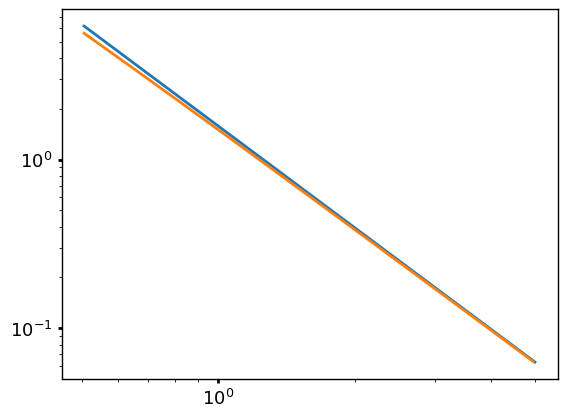

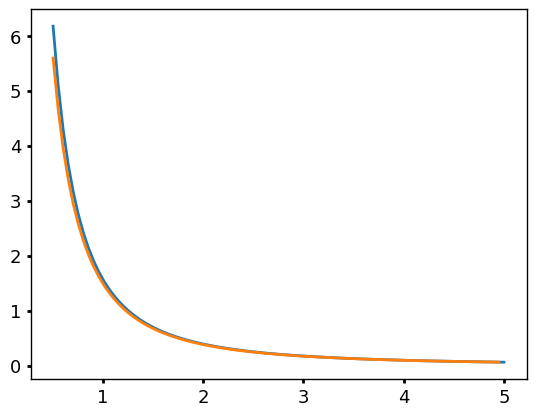

In [19]:
radial_grid = np.linspace(0, 5, 100)
deltar = radial_grid[1]-radial_grid[0]
cfp = dict(rate=0,
           scale=(4*np.pi*deltar)**(-1/2),
           exponent=2)

weights = (volsphere(radial_grid[1:])-volsphere(radial_grid[:-1]))
weights = 1/weights 

plt.loglog(radial_grid[10:], radialscaling(radial_grid[10:], cfp))
plt.loglog(radial_grid[10:][:-1], weights[10:])
plt.show()
plt.plot(radial_grid[10:], radialscaling(radial_grid[10:], cfp))
plt.plot(radial_grid[10:][:-1], weights[10:])
plt.show()

In [20]:
#methane
interaction_cutoff = 0
max_radial = 0
max_angular = -1
gaussian_sigma_constant = 0.3
cutoff_smooth_width = 0


hypers = dict(
    soap_type=None,
    interaction_cutoff=interaction_cutoff,
    cutoff_smooth_width=cutoff_smooth_width,
    max_radial=max_radial,
    max_angular=max_angular,
    gaussian_sigma_type="Constant",
    gaussian_sigma_constant=gaussian_sigma_constant,
    cutoff_function_type='RadialScaling',
    cutoff_function_parameters=cfp,
    radial_basis="DVR",
    compute_gradients=False,
    normalize=False,
)

In [21]:
from rascal.neighbourlist.structure_manager import mask_center_atoms_by_species

frames_H = copy.deepcopy(frames)
for frame in frames_H:
    mask_center_atoms_by_species(frame, [1])
    
frames_O = copy.deepcopy(frames)
for frame in frames_O:
    mask_center_atoms_by_species(frame, [8])

In [22]:
max_radials = list(range(4,36))
labels = ['$1^{st}$', '$2^{nd}$', '$3^{rd}$']
import matplotlib as mpl
norm = mpl.colors.Normalize(vmin=0, vmax=1)
red = mpl.cm.Reds(norm(0.9))
blue = mpl.cm.Blues(norm(0.9))
green = mpl.cm.Greens(norm(0.9))

In [23]:
path = pathlib.Path(os.path.join(RESULT_DIR, "atomrings/HH/nonopt/"))
path.mkdir(parents=True, exist_ok=True)


In [24]:
max_angular = 0
path_HH = pathlib.Path(os.path.join(RESULT_DIR, "atomrings/HH/nonopt/"))
path_HH.mkdir(parents=True, exist_ok=True)

print("max angular", max_angular)
for i, peak in enumerate(peaks_HH):
    cutoff = round(rings_range_HH[i][1], 2)
    print("  cutoff", cutoff, "peak", peak)
    for max_radial in max_radials+[100]:
        print("    max radial", max_radial)
        filename = os.path.join(path_HH,
                     f"features-rs-lmax{max_angular}-nmax{max_radial}-rc{cutoff}-gs-{gaussian_sigma_constant}-stride{stride}.npy")
        if not(os.path.exists(filename)):
            hypers_tmp = copy.deepcopy(hypers)
            #hypers_tmp['cutoff_smooth_width'] = rings_range_HH[i][1]-peak
            hypers_tmp['soap_type'] = 'RadialSpectrum'
            hypers_tmp['max_angular'] = 0
            hypers_tmp['interaction_cutoff'] = cutoff
            hypers_tmp['max_radial'] = max_radial
            #hypers_tmp = get_optimal_radial_basis_hypers(hypers_tmp, frames, expanded_max_radial=100)        
            calculator_nu1 = SphericalInvariants(**hypers_tmp)
            features_nu1_HH = calculator_nu1.transform(frames_H).get_features_by_species(calculator_nu1)[(1,)]
            np.save(filename, features_nu1_HH)

max angular 0
  cutoff 1.68 peak 1.56565657
    max radial 4
    max radial 5
    max radial 6
    max radial 7
    max radial 8
    max radial 9
    max radial 10
    max radial 11
    max radial 12
    max radial 13
    max radial 14
    max radial 15
    max radial 16
    max radial 17
    max radial 18
    max radial 19
    max radial 20
    max radial 21
    max radial 22
    max radial 23
    max radial 24
    max radial 25
    max radial 26
    max radial 27
    max radial 28
    max radial 29
    max radial 30
    max radial 31
    max radial 32
    max radial 33
    max radial 34
    max radial 35
    max radial 100
  cutoff 2.56 peak 2.07070707
    max radial 4
    max radial 5
    max radial 6
    max radial 7
    max radial 8
    max radial 9
    max radial 10
    max radial 11
    max radial 12
    max radial 13
    max radial 14
    max radial 15
    max radial 16
    max radial 17
    max radial 18
    max radial 19
    max radial 20
    max radial 21
    max radial 22
 

In [25]:
max_angular = 0
path_OH = pathlib.Path(os.path.join(RESULT_DIR, "atomrings/OH/nonopt/"))
path_OH.mkdir(parents=True, exist_ok=True)

print("max angular", max_angular)
for i in range(len(peaks_OH)):
    cutoff = round(rings_range_OH[i][1], 2)
    print("  ", cutoff)
    for max_radial in max_radials+[100]:
        filename = os.path.join(path_OH,
             f"features-rs-lmax{max_angular}-nmax{max_radial}-rc{cutoff}-gs-{gaussian_sigma_constant}-stride{stride}.npy")
        if not(os.path.exists(filename)):
            hypers_tmp = copy.deepcopy(hypers)
            hypers_tmp['soap_type'] = 'RadialSpectrum'
            hypers_tmp['max_angular'] = 0
            hypers_tmp['interaction_cutoff'] = cutoff
            hypers_tmp['max_radial'] = max_radial
            #hypers_tmp = get_optimal_radial_basis_hypers(hypers_tmp, frames, expanded_max_radial=100)
            calculator_nu1 = SphericalInvariants(**hypers_tmp)
            features_nu1_OH = calculator_nu1.transform(frames_O).get_features_by_species(calculator_nu1)[(1,)]
            np.save(filename, features_nu1_OH)

max angular 0
   1.2
   2
   3.5


In [26]:
max_angular = 0
path_OO = pathlib.Path(os.path.join(RESULT_DIR, "atomrings/OO/nonopt/"))
path_OO.mkdir(parents=True, exist_ok=True)

for i, peak in enumerate(peaks_OO):
    cutoff = round(rings_range_OO[i][1], 2)
    print(cutoff)
    for max_radial in max_radials+[100]:
        print("  ", max_radial)
        filename = os.path.join(path_OO,
            f"features-rs-lmax{max_angular}-nmax{max_radial}-rc{cutoff}-gs-{gaussian_sigma_constant}-stride{stride}.npy")
        if not(os.path.exists(filename)):
            hypers_tmp = copy.deepcopy(hypers)
            hypers_tmp['soap_type'] = 'RadialSpectrum'
            hypers_tmp['max_angular'] = 0
            hypers_tmp['interaction_cutoff'] = cutoff
            hypers_tmp['max_radial'] = max_radial
            #hypers_tmp = get_optimal_radial_basis_hypers(hypers_tmp, frames, expanded_max_radial=100)        
            calculator_nu1 = SphericalInvariants(**hypers_tmp)
            features_nu1_OO = calculator_nu1.transform(frames_O).get_features_by_species(calculator_nu1)[(8,)]
            np.save(filename, features_nu1_OO)


2.79
   4
   5
   6
   7
   8
   9
   10
   11
   12
   13
   14
   15
   16
   17
   18
   19
   20
   21
   22
   23
   24
   25
   26
   27
   28
   29
   30
   31
   32
   33
   34
   35
   100


In [27]:
max_angular = 0
path_HO = pathlib.Path(os.path.join(RESULT_DIR, "atomrings/HO/nonopt/"))
path_HO.mkdir(parents=True, exist_ok=True)

for i in range(len(peaks_HO)):
    cutoff = round(rings_range_HO[i][1], 2)
    print("  ", cutoff)
    for max_radial in max_radials+[100]:
        filename = os.path.join(path_HO,
            f"features-rs-lmax{max_angular}-nmax{max_radial}-rc{cutoff}-gs-{gaussian_sigma_constant}-stride{stride}.npy")
        if not(os.path.exists(filename)):
            hypers_tmp = copy.deepcopy(hypers)
            hypers_tmp['soap_type'] = 'RadialSpectrum'
            hypers_tmp['max_angular'] = 0
            hypers_tmp['interaction_cutoff'] = cutoff
            hypers_tmp['max_radial'] = max_radial
            #hypers_tmp = get_optimal_radial_basis_hypers(hypers_tmp, frames, expanded_max_radial=100)        
            calculator_nu1 = SphericalInvariants(**hypers_tmp)
            features_nu1_HO = calculator_nu1.transform(frames_H).get_features_by_species(calculator_nu1)[(8,)]
            np.save(filename, features_nu1_HO)


   1.2
   2
   2.85


In [28]:
GFRE_RS_CONV_FILENAME = 'gfre_rs_conv_results.pkl'
GFRE_RS_CONV_ABSPATH = os.path.join(RESULT_DIR, GFRE_RS_CONV_FILENAME)
GFRE_RS_SELFCONV_FILENAME =' gfre_rs_selfconv_results.pkl'
GFRE_RS_SELFCONV_ABSPATH = os.path.join(RESULT_DIR, GFRE_RS_SELFCONV_FILENAME)

In [29]:
gfre_rs_conv = nested_dict()
gfre_rs_selfconv = nested_dict()

### Looking for explanation why OO bonds need more basis function than HH. Probably because HH has more overlap with the center distribution and more environments without a neighbourshell

In [30]:
max_angular = 0
max_radial = 100
cutoff = round(rings_range_HH[0][1], 2)
ground_truth_HH = np.load(
    os.path.join(path_HH,
        f'features-rs-lmax{max_angular}-nmax100-rc{cutoff}-gs-{gaussian_sigma_constant}-stride{stride}.npy'
    )
)
cutoff = round(rings_range_OO[0][1], 2)
ground_truth_OO = np.load(
    os.path.join(path_OO,
        f'features-rs-lmax{max_angular}-nmax100-rc{cutoff}-gs-{gaussian_sigma_constant}-stride{stride}.npy'
    )
)

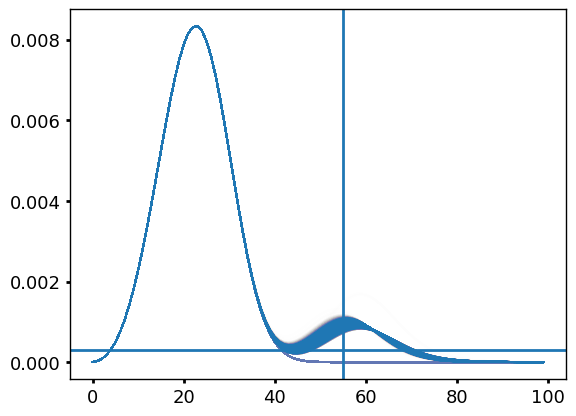

In [31]:
plt.plot(ground_truth_HH[::100].T, color='C0', alpha=0.005)
plt.axhline(0.0003)
plt.axvline(55)
plt.show()

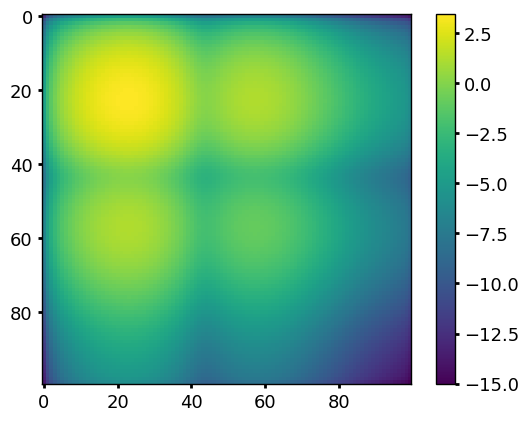

In [32]:
plt.imshow(np.log(ground_truth_HH.T@ground_truth_HH))
plt.colorbar()
plt.show()

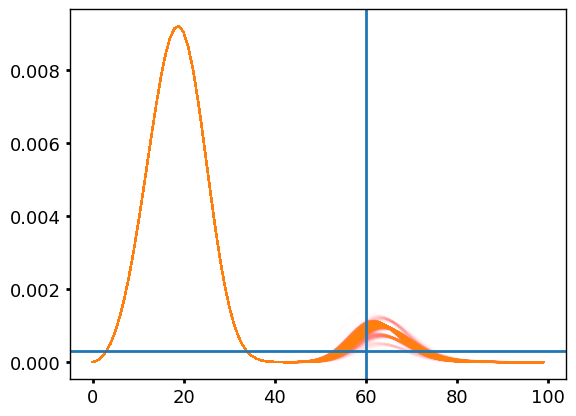

In [33]:
plt.plot(ground_truth_OO[::100].T, color='C1', alpha=0.003)
plt.axhline(0.0003)
plt.axvline(60)
plt.show()

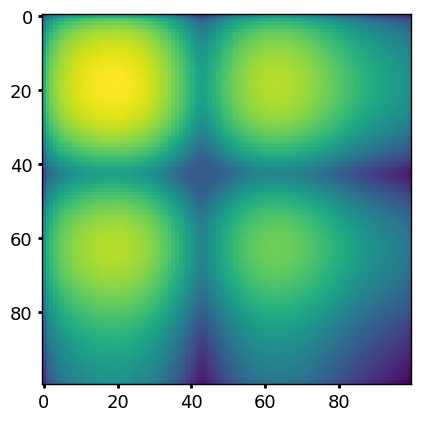

In [34]:
plt.imshow(np.log(ground_truth_OO.T@ground_truth_OO))
plt.show()

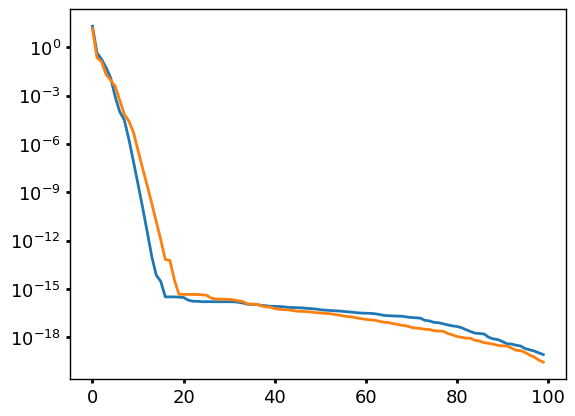

In [35]:
plt.semilogy(np.linalg.svd(ground_truth_HH, compute_uv=False))
plt.semilogy(np.linalg.svd(ground_truth_OO, compute_uv=False))
plt.show()

In [36]:
print(len(ground_truth_HH))
print(len(ground_truth_OO))
print()
print(sum(ground_truth_HH[:, 55] > 0.0003)/len(ground_truth_HH))
print(sum(ground_truth_OO[:, 60] > 0.0003)/len(ground_truth_OO))

448928
224464

0.9660836481573882
0.9983427186542163


In [37]:
from skmatter.linear_model import RidgeRegression2FoldCV
from skmatter.model_selection import train_test_split
from sklearn.decomposition import PCA

estimator = RidgeRegression2FoldCV(
    alphas=np.geomspace(1e-15, 1e-3, 100),
    alpha_type="relative",
    regularization_method="tikhonov",
    random_state=0x5F3759DF,
    shuffle=True,
    scoring="neg_root_mean_squared_error",
    n_jobs=4,
)

scaler = StandardFlexibleScaler(with_mean=True)

In [38]:
max_angular = 0
errs = []
for i in range(len(peaks_HH)):
    cutoff = round(rings_range_HH[i][1], 2)
    print("cutoff", cutoff)
    
    ground_truth = np.load(
        os.path.join(path_HH, f'features-rs-lmax{max_angular}-nmax100-rc{cutoff}-gs-{gaussian_sigma_constant}-stride{stride}.npy')
    )
    #ground_truth = ground_truth[ground_truth_HH[:, 55] > 0.0003]
    ground_truth = scaler.fit_transform(ground_truth)
    ground_truth_proj = PCA(whiten=False, n_components=np.max(max_radials)+1, svd_solver='full').fit_transform(ground_truth)
    for max_radial in max_radials:

        X = ground_truth_proj[:, :max_radial]
        Y = ground_truth_proj[:, :max_radial+1]
        
        err = []
        for i in range(10):
            train_idx, test_idx = train_test_split(
                np.arange(len(X)),
                test_size=0.5,
                train_size=0.5,
                random_state=i,
                shuffle=True,
                train_test_overlap=False,
            )

            err.append( global_reconstruction_error(X, Y,
                estimator=estimator,
                scaler=scaler,
                train_idx=train_idx,
                test_idx=test_idx

            ))
        gfre_rs_conv['HH'][str(cutoff)][str(gaussian_sigma_constant)][str(max_angular)][str(max_radial)] = err
        errs.append(err)
        print("  ", max_radial, "mean(err), std(err)", np.mean(err), np.std(err))

cutoff 1.68
   4 mean(err), std(err) 0.0018629114280526594 5.467786353249859e-05
   5 mean(err), std(err) 0.0004846092145175945 0.00019256143463151955
   6 mean(err), std(err) 0.0003322513492336431 0.0002469735264229447
   7 mean(err), std(err) 0.00019377207548854398 0.00018869425181399722
   8 mean(err), std(err) 0.00011105356760441037 0.00011085717074178078
   9 mean(err), std(err) 5.877704027856764e-05 5.879007563308158e-05
   10 mean(err), std(err) 3.803127984859858e-05 3.8055117040558324e-05
   11 mean(err), std(err) 3.885223751439017e-05 3.887445117781948e-05
   12 mean(err), std(err) 3.885224133957228e-05 3.887445482478635e-05
   13 mean(err), std(err) 3.885224134207141e-05 3.8874454827284994e-05
   14 mean(err), std(err) 3.8852241342074404e-05 3.887445482728765e-05
   15 mean(err), std(err) 3.8852241342068685e-05 3.887445482728179e-05
   16 mean(err), std(err) 3.885224134206791e-05 3.8874454827281084e-05
   17 mean(err), std(err) 3.88522413420631e-05 3.887445482727631e-05
   18

In [39]:
max_angular = 0
errs = []
for i in range(len(peaks_HH)):
    cutoff = round(rings_range_HH[i][1], 2)
    print("cutoff", cutoff)
    ground_truth = np.load(
        os.path.join(path_HH, f'features-rs-lmax{max_angular}-nmax100-rc{cutoff}-gs-{gaussian_sigma_constant}-stride{stride}.npy')
    )
    ground_truth = scaler.fit_transform(ground_truth)
    #ground_truth_proj = PCA(whiten=False, n_components=np.max(max_radials)+1, svd_solver='full').fit_transform(ground_truth)
    for max_radial in [100]:

        X = ground_truth
        Y = ground_truth
        
        err = []
        for i in range(10):
            train_idx, test_idx = train_test_split(
                np.arange(len(X)),
                test_size=0.5,
                train_size=0.5,
                random_state=i,
                shuffle=True,
                train_test_overlap=False,
            )

            err.append( global_reconstruction_error(X, Y,
                estimator=estimator,
                scaler=scaler,
                train_idx=train_idx,
                test_idx=test_idx

            ))
        gfre_rs_selfconv['HH'][str(cutoff)][str(gaussian_sigma_constant)][str(max_angular)][str(max_radial)] = err
        errs.append(err)
        print("  ", max_radial, "mean(err), std(err)", np.mean(err), np.std(err))

cutoff 1.68
   100 mean(err), std(err) 3.8852241326268925e-05 3.887445481156096e-05
cutoff 2.56
   100 mean(err), std(err) 6.640005969099458e-06 6.643192905826975e-06
cutoff 4.61
   100 mean(err), std(err) 4.568681713854179e-06 4.570370950761964e-06


cutoff 1.68
cutoff 2.56
cutoff 4.61


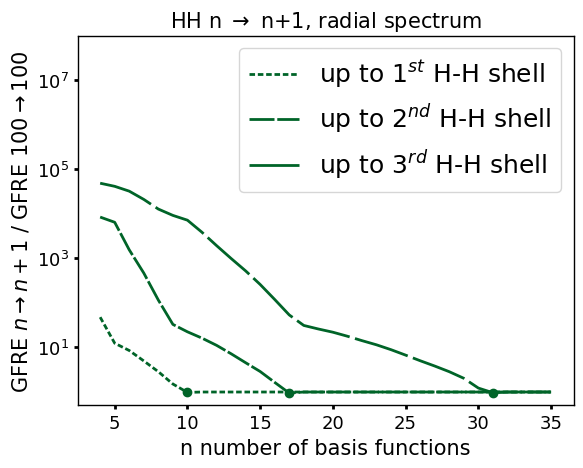

In [40]:
max_angular = 0
linestyles = [(0, (2, 1)), (0, (9, 1)), (0, (20, 2))]
converged_nb_bf_HH = [10, 17, 31]
for i in range(len(peaks_HH)):
    cutoff = round(rings_range_HH[i][1], 2)
    print("cutoff", cutoff)
    gfre_nmax_HH = [gfre_rs_conv['HH'][str(cutoff)][str(gaussian_sigma_constant)][str(max_angular)][str(max_radial)] for max_radial in max_radials]
    #[3.885224145223666e-05, 6.640005972947598e-06, 4.568681730980801e-06][i]
    ref = np.mean(gfre_rs_selfconv['HH'][str(cutoff)][str(gaussian_sigma_constant)][str(max_angular)][str(100)])
    # errorbar not needed because so small
    #plt.errorbar(max_radials,
    #             np.mean(gfre_nmax_HH, axis=1),
    #             yerr=np.var(gfre_nmax_HH, axis=1),
    #             label=f'$r_c={cutoff}$', color='C0', linestyle=linestyles[i])
    plt.plot(max_radials,
             np.mean(gfre_nmax_HH, axis=1)/ref,
             label='up to '+labels[i]+' H-H shell', color=green, linestyle=linestyles[i])
    #print(np.mean(gfre_nmax_HH, axis=1))
    plt.scatter(converged_nb_bf_HH[i:i+1], np.mean(gfre_nmax_HH, axis=1)[converged_nb_bf_HH[i]-np.min(max_radials)]/ref, color=green)
plt.yscale('log')
plt.xticks(np.arange(5,36,5))
plt.title('HH n $\\rightarrow$ n+1, radial spectrum', usetex=False)
plt.ylabel('GFRE $n \\rightarrow n+1$ / GFRE $100 \\rightarrow 100$ ')
plt.xlabel('n number of basis functions')
plt.ylim(0.5,1e8)
plt.legend()
#plt.savefig('gfre_radial_basis_function_convergence-rs-HH.png')
#plt.savefig('gfre_radial_basis_function_convergence-rs-HH.svg')
plt.show()

cutoff 1.68
cutoff 2.56
cutoff 4.61


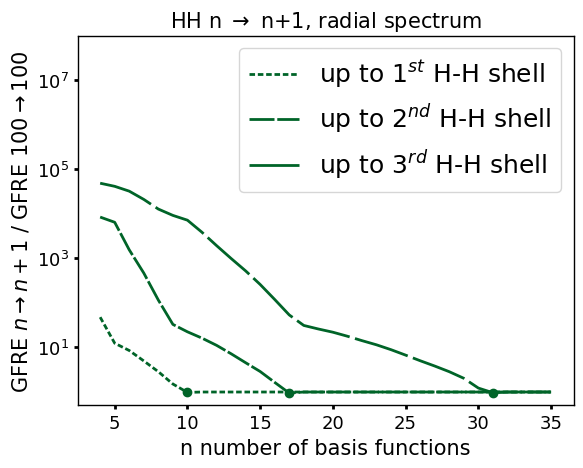

In [41]:
max_angular = 0
linestyles = [(0, (2, 1)), (0, (9, 1)), (0, (20, 2))]
converged_nb_bf_HH = [10, 17, 31]
for i in range(len(peaks_HH)):
    cutoff = round(rings_range_HH[i][1], 2)
    print("cutoff", cutoff)
    gfre_nmax_HH = [gfre_rs_conv['HH'][str(cutoff)][str(gaussian_sigma_constant)][str(max_angular)][str(max_radial)] for max_radial in max_radials]
    #[3.885224145223666e-05, 6.640005972947598e-06, 4.568681730980801e-06][i]
    ref = np.mean(gfre_rs_selfconv['HH'][str(cutoff)][str(gaussian_sigma_constant)][str(max_angular)][str(100)])
    # errorbar not needed because so small
    #plt.errorbar(max_radials,
    #             np.mean(gfre_nmax_HH, axis=1),
    #             yerr=np.var(gfre_nmax_HH, axis=1),
    #             label=f'$r_c={cutoff}$', color='C0', linestyle=linestyles[i])
    plt.plot(max_radials,
             np.mean(gfre_nmax_HH, axis=1)/ref,
             label='up to '+labels[i]+' H-H shell', color=green, linestyle=linestyles[i])
    #print(np.mean(gfre_nmax_HH, axis=1))
    plt.scatter(converged_nb_bf_HH[i:i+1], np.mean(gfre_nmax_HH, axis=1)[converged_nb_bf_HH[i]-np.min(max_radials)]/ref, color=green)
plt.yscale('log')
plt.xticks(np.arange(5,36,5))
plt.title('HH n $\\rightarrow$ n+1, radial spectrum', usetex=False)
plt.ylabel('GFRE $n \\rightarrow n+1$ / GFRE $100 \\rightarrow 100$ ')
plt.xlabel('n number of basis functions')
plt.ylim(0.5,1e8)
plt.legend()
#plt.savefig('gfre_radial_basis_function_convergence-rs-HH.png')
#plt.savefig('gfre_radial_basis_function_convergence-rs-HH.svg')
plt.show()

In [42]:
max_angular = 0
errs = []
for i in range(len(peaks_OH)):
    cutoff = round(rings_range_OH[i][1], 2)
    print("cutoff", cutoff)
    ground_truth = np.load(
        os.path.join(path_OH, f'features-rs-lmax{max_angular}-nmax100-rc{cutoff}-gs-{gaussian_sigma_constant}-stride{stride}.npy')
    )
    ground_truth = scaler.fit_transform(ground_truth)
    ground_truth_proj = PCA(whiten=False, n_components=np.max(max_radials)+1, svd_solver='full').fit_transform(ground_truth)
    for max_radial in max_radials:

        X = ground_truth_proj[:, :max_radial]
        Y = ground_truth_proj[:, :max_radial+1]
        
        err = []
        for i in range(10):
            train_idx, test_idx = train_test_split(
                np.arange(len(X)),
                test_size=0.5,
                train_size=0.5,
                random_state=i,
                shuffle=True,
                train_test_overlap=False,
            )

            err.append( global_reconstruction_error(X, Y,
                estimator=estimator,
                scaler=scaler,
                train_idx=train_idx,
                test_idx=test_idx

            ))
        gfre_rs_conv['OH'][str(cutoff)][str(gaussian_sigma_constant)][str(max_angular)][str(max_radial)] = err
        errs.append(err)
        print("  ", max_radial, "mean(err), std(err)", np.mean(err), np.std(err))


cutoff 1.2
   4 mean(err), std(err) 0.00035946297657506117 1.0007124919114513e-05
   5 mean(err), std(err) 2.8488850657194684e-05 1.102331495777872e-06
   6 mean(err), std(err) 1.5173652649724335e-06 3.851283316231643e-08
   7 mean(err), std(err) 6.336369742118845e-08 1.986421293980106e-09
   8 mean(err), std(err) 3.269157884617093e-09 1.0910376923358677e-10
   9 mean(err), std(err) 5.510686149739179e-10 4.74117453282226e-11
   10 mean(err), std(err) 5.507378188379226e-10 4.7435730524887746e-11
   11 mean(err), std(err) 5.50737860907921e-10 4.743572766133074e-11
   12 mean(err), std(err) 5.507378609190778e-10 4.7435727662442736e-11
   13 mean(err), std(err) 5.507378609196133e-10 4.743572766240269e-11
   14 mean(err), std(err) 5.507378609202455e-10 4.743572766234754e-11
   15 mean(err), std(err) 5.507378609207905e-10 4.743572766230148e-11
   16 mean(err), std(err) 5.507378609211206e-10 4.743572766226757e-11
   17 mean(err), std(err) 5.507378609213831e-10 4.743572766225755e-11
   18 mean

In [43]:
max_angular = 0
errs = []
for i in range(len(peaks_OH)):
    cutoff = round(rings_range_OH[i][1], 2)
    print("cutoff", cutoff)
    ground_truth = np.load(
        os.path.join(path_OH, f'features-rs-lmax{max_angular}-nmax100-rc{cutoff}-gs-{gaussian_sigma_constant}-stride{stride}.npy')
    )
    ground_truth = scaler.fit_transform(ground_truth)
    #ground_truth_proj = PCA(whiten=False, n_components=np.max(max_radials)+1, svd_solver='full').fit_transform(ground_truth)
    for max_radial in [100]:

        X = ground_truth
        Y = ground_truth
        
        err = []
        for i in range(10):
            train_idx, test_idx = train_test_split(
                np.arange(len(X)),
                test_size=0.5,
                train_size=0.5,
                random_state=i,
                shuffle=True,
                train_test_overlap=False,
            )

            err.append( global_reconstruction_error(X, Y,
                estimator=estimator,
                scaler=scaler,
                train_idx=train_idx,
                test_idx=test_idx

            ))
        gfre_rs_selfconv['OH'][str(cutoff)][str(gaussian_sigma_constant)][str(max_angular)][str(max_radial)] = err
        errs.append(err)
        print("  ", max_radial, "mean(err), std(err)", np.mean(err), np.std(err))


cutoff 1.2
   100 mean(err), std(err) 5.507378609896405e-10 4.7435728835948025e-11
cutoff 2
   100 mean(err), std(err) 5.854225453221204e-10 1.4219961144828556e-11
cutoff 3.5
   100 mean(err), std(err) 7.68275586496907e-10 1.0096620556970464e-11


cutoff 1.2
cutoff 2
cutoff 3.5


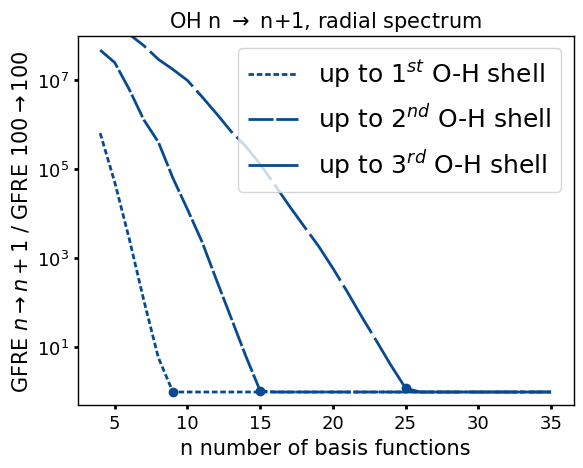

In [44]:
max_angular = 0
linestyles = [(0, (2, 1)), (0, (9, 1)), (0, (20, 2))]
converged_nb_bf_OH = [9, 15, 25]
for i in range(len(peaks_OH)):
    cutoff = round(rings_range_OH[i][1], 2)
    print("cutoff", cutoff)
    gfre_nmax_OH = [gfre_rs_conv['OH'][str(cutoff)][str(gaussian_sigma_constant)][str(max_angular)][str(max_radial)] for max_radial in max_radials]
    ref = np.mean(gfre_rs_selfconv['OH'][str(cutoff)][str(gaussian_sigma_constant)][str(max_angular)][str(100)])
    # errorbar not needed because so small
    #plt.errorbar(max_radials,
    #             np.mean(gfre_nmax_OH, axis=1),
    #             yerr=np.var(gfre_nmax_OH, axis=1),
    #             label=f'$r_c={cutoff}$', color='C0', linestyle=linestyles[i])
    plt.plot(max_radials,
             np.mean(gfre_nmax_OH, axis=1)/ref,
             label="up to "+labels[i]+' O-H shell', color=blue, linestyle=linestyles[i])
    #print(np.mean(gfre_nmax_OH, axis=1))
    plt.scatter(converged_nb_bf_OH[i:i+1], np.mean(gfre_nmax_OH, axis=1)[converged_nb_bf_OH[i]-np.min(max_radials)]/ref, color=blue)
plt.yscale('log')
plt.xticks(np.arange(5,36,5))
plt.title('OH n $\\rightarrow$ n+1, radial spectrum', usetex=False)
plt.ylabel('GFRE $n \\rightarrow n+1$ / GFRE $100 \\rightarrow 100$ ')
plt.xlabel('n number of basis functions')
plt.ylim(0.5,1e8)
plt.legend()
plt.savefig('gfre_radial_basis_function_convergence-rs-OH.png')
plt.savefig('gfre_radial_basis_function_convergence-rs-OH.svg')
plt.show()


### Experiment with dimers

(array([  3.,  17.,  45., 118., 229., 248., 210.,  94.,  30.,   6.]),
 array([0.82806572, 0.86060521, 0.8931447 , 0.92568419, 0.95822368,
        0.99076316, 1.02330265, 1.05584214, 1.08838163, 1.12092112,
        1.15346061]),
 <BarContainer object of 10 artists>)

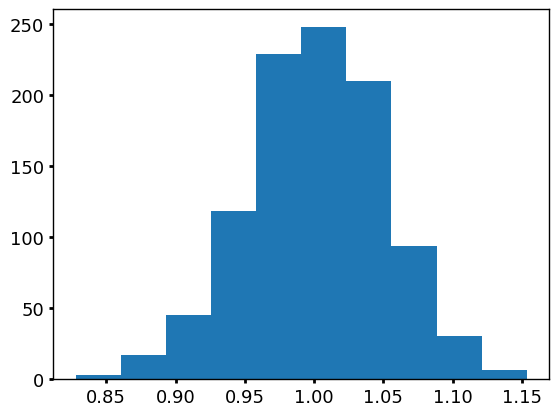

In [45]:
rij = np.random.normal(loc=1, scale=0.05, size=1000)
plt.hist(rij)

In [46]:
artifical_peaks = [0.5, 1, 1.5, 2]
scale = 0.05
features_dimer = []
for peak in artifical_peaks:
    np.random.seed(0)
    rij = np.random.normal(loc=peak, scale=scale, size=1000)
    frames_dimer = [ase.Atoms('HH', positions=[[0,0,0], [0,0,rij[i]]], cell=[50,50,50], pbc=False)
                    for i in range(len(rij))]
    for frame in frames:
        frame.center()
    cutoff = scale
    hypers_tmp = copy.deepcopy(hypers)
    hypers_tmp['soap_type'] = 'RadialSpectrum'
    hypers_tmp['max_angular'] = 0
    hypers_tmp['interaction_cutoff'] = peak+0.3
    hypers_tmp['gaussian_sigma_constant'] = 0.1
    hypers_tmp['max_radial'] = 50
    hypers_tmp.pop('cutoff_function_type')
    hypers_tmp.pop('cutoff_function_parameters')
    #hypers_tmp = get_optimal_radial_basis_hypers(hypers_tmp, frames, expanded_max_radial=100)
    calculator_nu1 = SphericalInvariants(**hypers_tmp)
    features_dimer.append( calculator_nu1.transform(frames_dimer).get_features(calculator_nu1) )

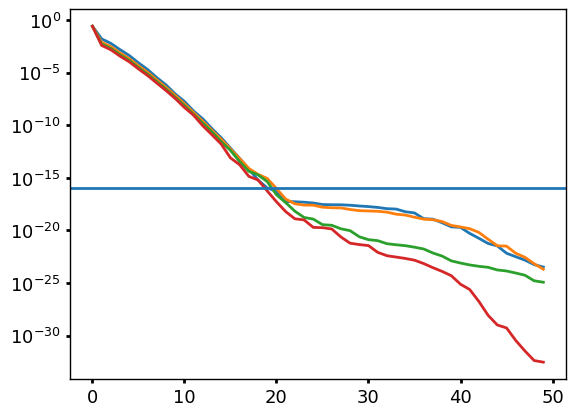

In [47]:
for i in range(len(features_dimer)):
    plt.semilogy(np.linalg.svd(features_dimer[i], compute_uv=False))
plt.axhline(1e-16)
plt.show()

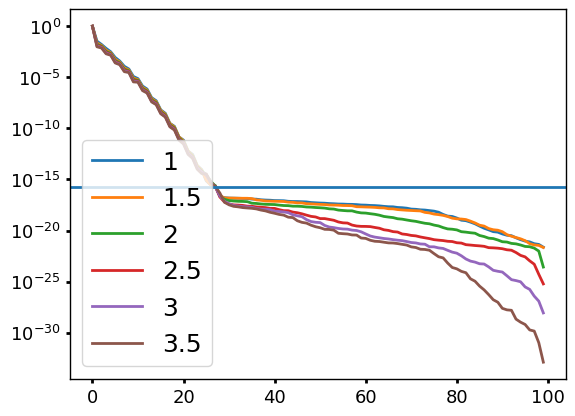

In [48]:
artifical_peaks = [1, 1.5, 2, 2.5, 3, 3.5]
scale = 0.05

for peak in artifical_peaks:
    np.random.seed(0)
    rij = np.random.normal(loc=peak, scale=scale, size=1000)
    rij2 = np.random.normal(loc=peak+1, scale=scale, size=1000)
    features_dimer = []
    frames_dimer = [ase.Atoms('HHH', positions=[[0,0,0], [0,0,rij[i]], [0,0,rij2[i]]], cell=[50,50,50], pbc=False)
                    for i in range(len(rij))]
    for frame in frames:
        frame.center()
    cutoff = scale
    hypers_tmp = copy.deepcopy(hypers)
    hypers_tmp['soap_type'] = 'RadialSpectrum'
    hypers_tmp['max_angular'] = 0
    hypers_tmp['interaction_cutoff'] = peak+1+0.3
    hypers_tmp['gaussian_sigma_constant'] = 0.2
    hypers_tmp['max_radial'] = 100
    hypers_tmp.pop('cutoff_function_type')
    hypers_tmp.pop('cutoff_function_parameters')
    #hypers_tmp = get_optimal_radial_basis_hypers(hypers_tmp, frames, expanded_max_radial=100)
    calculator_nu1 = SphericalInvariants(**hypers_tmp)
    #features_dimer.append( calculator_nu1.transform(frames_dimer).get_features(calculator_nu1) )
    features_dimer = calculator_nu1.transform(frames_dimer).get_features(calculator_nu1)[::len(frames_dimer[0])]
    x, w = np.polynomial.legendre.leggauss(hypers_tmp['max_radial'])
    x = (x+1)/2*(hypers_tmp['interaction_cutoff']+3*hypers_tmp['gaussian_sigma_constant'])
    svals = np.linalg.svd(features_dimer, compute_uv=False)
    plt.semilogy(svals/svals[0], label=peak)
plt.axhline(2e-16)
plt.legend()
plt.show()

16
29
44


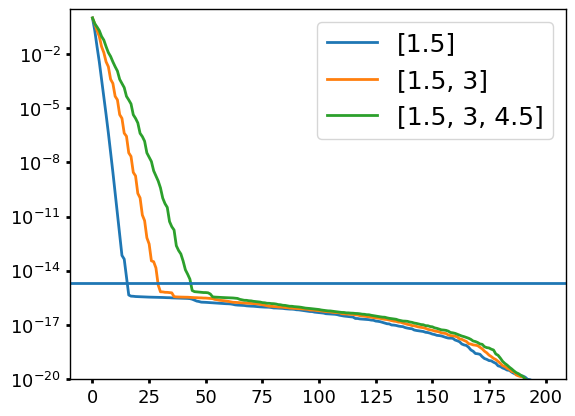

In [49]:
artifical_peaks = [1.5, 3, 4.5]
scale = 0.05

for n in range(1, len(artifical_peaks)+1):
    np.random.seed(0)
    rij = [np.random.normal(loc=peak, scale=scale, size=1000) for peak in artifical_peaks[:n]]
    rij = np.vstack((np.zeros(1000), rij))
    frames_dimer = [ase.Atoms('H'*len(rij), positions=[[0,0,rij[k][i]] for k in range(len(rij))]
                              , cell=[50,50,50], pbc=False)
                    for i in range(len(rij.T))]
    for frame in frames:
        frame.center()
    cutoff = scale
    hypers_tmp = copy.deepcopy(hypers)
    hypers_tmp['soap_type'] = 'RadialSpectrum'
    hypers_tmp['max_angular'] = 0
    hypers_tmp['interaction_cutoff'] = np.max(artifical_peaks[:n])+0.3
    hypers_tmp['gaussian_sigma_constant'] = 0.2
    hypers_tmp['max_radial'] = 200
    hypers_tmp.pop('cutoff_function_type')
    hypers_tmp.pop('cutoff_function_parameters')
    #hypers_tmp = get_optimal_radial_basis_hypers(hypers_tmp, frames, expanded_max_radial=100)
    calculator_nu1 = SphericalInvariants(**hypers_tmp)
    #features_dimer.append( calculator_nu1.transform(frames_dimer).get_features(calculator_nu1) )
    features_dimer = calculator_nu1.transform(frames_dimer).get_features(calculator_nu1)[::len(frames_dimer[0])]
    features_dimer -= np.mean(features_dimer, axis=0)
    svals = np.linalg.svd(features_dimer, compute_uv=False)
    plt.semilogy(svals/svals[0], label=artifical_peaks[:n])
    print(np.argmax(svals/svals[0] <= 2e-15))
plt.axhline(2e-15)
plt.ylim(1e-20, 3)
plt.legend()
plt.show()

In [50]:
max_angular = 0
errs = []
artifical_peaks = [1.5, 1.5+0.3*6, 1.5+0.3*12]
for n in range(1, len(artifical_peaks)+1):
    print("peak", artifical_peaks[n-1])
    np.random.seed(0)
    rij = [np.random.normal(loc=peak, scale=scale, size=1000) for peak in artifical_peaks[:n]]
    rij = np.vstack((np.zeros(1000), rij))
    frames_dimer = [ase.Atoms('H'*len(rij), positions=[[0,0,rij[k][i]] for k in range(len(rij))]
                              , cell=[50,50,50], pbc=False)
                    for i in range(len(rij.T))]
    for frame in frames:
        frame.center()
    cutoff = scale
    hypers_tmp = copy.deepcopy(hypers)
    hypers_tmp['soap_type'] = 'RadialSpectrum'
    hypers_tmp['max_angular'] = 0
    hypers_tmp['interaction_cutoff'] = np.max(artifical_peaks[:n])+3*0.3
    hypers_tmp['gaussian_sigma_constant'] = 0.3
    hypers_tmp['max_radial'] = 100
    hypers_tmp.pop('cutoff_function_type')
    hypers_tmp.pop('cutoff_function_parameters')
    #hypers_tmp = get_optimal_radial_basis_hypers(hypers_tmp, frames, expanded_max_radial=100)
    calculator_nu1 = SphericalInvariants(**hypers_tmp)
    #features_dimer.append( calculator_nu1.transform(frames_dimer).get_features(calculator_nu1) )
    ground_truth = calculator_nu1.transform(frames_dimer).get_features(calculator_nu1)[::len(frames_dimer[0])]
    
    ground_truth = scaler.fit_transform(ground_truth)
    ground_truth_proj = PCA(whiten=False, n_components=np.max(max_radials)+1, svd_solver='full').fit_transform(ground_truth)
    for max_radial in range(4,16, 1):

        X = ground_truth_proj[:, :max_radial]
        Y = ground_truth_proj[:, :max_radial+1]
        
        err = []
        for i in range(10):
            train_idx, test_idx = train_test_split(
                np.arange(len(X)),
                test_size=0.5,
                train_size=0.5,
                random_state=i,
                shuffle=True,
                train_test_overlap=False,
            )

            err.append( global_reconstruction_error(X, Y,
                estimator=estimator,
                scaler=scaler,
                train_idx=train_idx,
                test_idx=test_idx

            ))
        #gfre_rs_conv['OO'][str(cutoff)][str(gaussian_sigma_constant)][str(max_angular)][str(max_radial)] = err
        errs.append(err)
        print("  ", max_radial, "mean(err), std(err)", np.mean(err), np.std(err))


peak 1.5
   4 mean(err), std(err) 7.98592867247143e-05 9.5561053762531e-06
   5 mean(err), std(err) 6.544026899437248e-06 1.2564113093304733e-06
   6 mean(err), std(err) 5.077103711690259e-07 1.3686493551414622e-07
   7 mean(err), std(err) 3.77296329376167e-08 1.3216215813972495e-08
   8 mean(err), std(err) 3.5860525693178627e-09 1.794365824483384e-09
   9 mean(err), std(err) 3.557844491563225e-09 1.8272297722803803e-09
   10 mean(err), std(err) 3.5579277009777523e-09 1.8273042119567779e-09
   11 mean(err), std(err) 3.5579278382105567e-09 1.8273043113319333e-09
   12 mean(err), std(err) 3.5579278384052734e-09 1.8273043114322126e-09
   13 mean(err), std(err) 3.557927838405747e-09 1.82730431143229e-09
   14 mean(err), std(err) 3.55792783840588e-09 1.8273043114322296e-09
   15 mean(err), std(err) 3.5579278384059806e-09 1.8273043114321853e-09
peak 3.3
   4 mean(err), std(err) 0.010423008534180876 0.0006525475223349225
   5 mean(err), std(err) 0.004460973127338008 0.0005413948044235186
   6

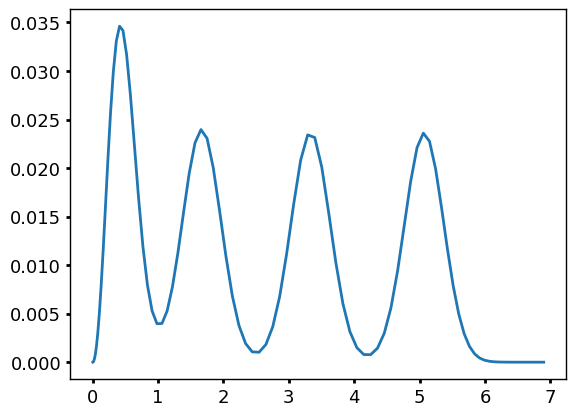

In [51]:
x, w = np.polynomial.legendre.leggauss(hypers_tmp['max_radial'])
x = (x+1)/2*(hypers_tmp['interaction_cutoff']+3*hypers_tmp['gaussian_sigma_constant'])
features_dimer = calculator_nu1.transform(frames_dimer).get_features(calculator_nu1)[::len(frames_dimer[0])]
plt.plot(x, x*features_dimer[3]/np.sqrt(w))

In [52]:
max_angular = 0
errs = []
for i in range(len(peaks_OO)):
    cutoff = round(rings_range_OO[i][1], 2)
    print("cutoff", cutoff)
    ground_truth = np.load(
        os.path.join(path_OO, f'features-rs-lmax{max_angular}-nmax100-rc{cutoff}-gs-{gaussian_sigma_constant}-stride{stride}.npy')
    )
    ground_truth = scaler.fit_transform(ground_truth)
    ground_truth_proj = PCA(whiten=False, n_components=np.max(max_radials)+1, svd_solver='full').fit_transform(ground_truth)
    for max_radial in max_radials:

        X = ground_truth_proj[:, :max_radial]
        Y = ground_truth_proj[:, :max_radial+1]
        
        err = []
        for i in range(10):
            train_idx, test_idx = train_test_split(
                np.arange(len(X)),
                test_size=0.5,
                train_size=0.5,
                random_state=i,
                shuffle=True,
                train_test_overlap=False,
            )

            err.append( global_reconstruction_error(X, Y,
                estimator=estimator,
                scaler=scaler,
                train_idx=train_idx,
                test_idx=test_idx

            ))
        gfre_rs_conv['OO'][str(cutoff)][str(gaussian_sigma_constant)][str(max_angular)][str(max_radial)] = err
        errs.append(err)
        print("  ", max_radial, "mean(err), std(err)", np.mean(err), np.std(err))


cutoff 2.79
   4 mean(err), std(err) 0.014661457084232634 0.00028104614289863375
   5 mean(err), std(err) 0.0019241738739738678 2.1776582287009404e-05
   6 mean(err), std(err) 0.00041222167767759985 0.00021243428436194518
   7 mean(err), std(err) 0.00014212430200467489 5.428833888856177e-05
   8 mean(err), std(err) 0.00011773667261975801 0.00011897163286362126
   9 mean(err), std(err) 7.9929954829431e-05 9.59821611703754e-05
   10 mean(err), std(err) 5.291210351098632e-05 6.465907924273606e-05
   11 mean(err), std(err) 3.367210526490208e-05 4.123307060659255e-05
   12 mean(err), std(err) 1.8434516424833344e-05 2.2580136598177977e-05
   13 mean(err), std(err) 1.949351279103784e-05 2.3877403864391283e-05
   14 mean(err), std(err) 1.9493702388803276e-05 2.387763585877104e-05
   15 mean(err), std(err) 1.9493702415317996e-05 2.3877635890916483e-05
   16 mean(err), std(err) 1.9493702415358047e-05 2.3877635890965055e-05
   17 mean(err), std(err) 1.949370241535672e-05 2.3877635890963456e-05
  

In [53]:
max_angular = 0
errs = []
for i in range(len(peaks_OO)):
    cutoff = round(rings_range_OO[i][1], 2)
    print("cutoff", cutoff)
    ground_truth = np.load(
        os.path.join(path_OO, f'features-rs-lmax{max_angular}-nmax100-rc{cutoff}-gs-{gaussian_sigma_constant}-stride{stride}.npy')
    )
    ground_truth = scaler.fit_transform(ground_truth)
    #ground_truth_proj = PCA(whiten=False, n_components=np.max(max_radials)+1, svd_solver='full').fit_transform(ground_truth)
    for max_radial in [100]:

        X = ground_truth
        Y = ground_truth
        
        err = []
        for i in range(10):
            train_idx, test_idx = train_test_split(
                np.arange(len(X)),
                test_size=0.5,
                train_size=0.5,
                random_state=i,
                shuffle=True,
                train_test_overlap=False,
            )

            err.append( global_reconstruction_error(X, Y,
                estimator=estimator,
                scaler=scaler,
                train_idx=train_idx,
                test_idx=test_idx

            ))
        gfre_rs_selfconv['OO'][str(cutoff)][str(gaussian_sigma_constant)][str(max_angular)][str(max_radial)] = err
        errs.append(err)
        print("  ", max_radial, "mean(err), std(err)", np.mean(err), np.std(err))


cutoff 2.79
   100 mean(err), std(err) 1.9493702423016092e-05 2.3877635900386972e-05


cutoff 2.79


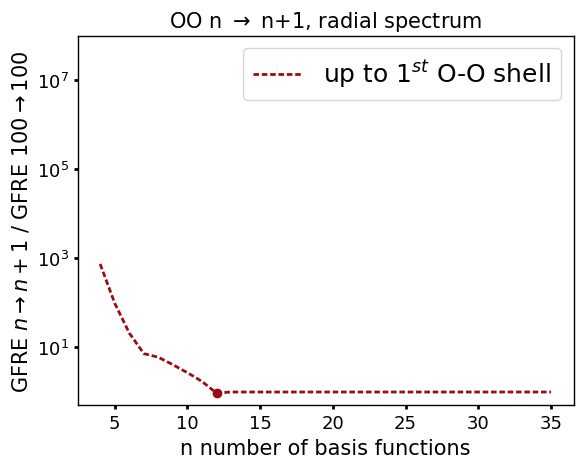

In [54]:
max_angular = 0
linestyles = [(0, (2, 1)), (0, (9, 1)), (0, (20, 2))]
converged_nb_bf_OO = [12]
for i in range(len(peaks_OO)):
    cutoff = round(rings_range_OO[i][1], 2)
    print("cutoff", cutoff)
    gfre_nmax_OO = [gfre_rs_conv['OO'][str(cutoff)][str(gaussian_sigma_constant)][str(max_angular)][str(max_radial)] for max_radial in max_radials]
    ref = np.mean(gfre_rs_selfconv['OO'][str(cutoff)][str(gaussian_sigma_constant)][str(max_angular)][str(100)])

    # errorbar not needed because so small
    #plt.errorbar(max_radials,
    #             np.mean(gfre_nmax_OO, axis=1),
    #             yerr=np.var(gfre_nmax_OO, axis=1),
    #             label=f'$r_c={cutoff}$', color='C0', linestyle=linestyles[i])
    plt.plot(max_radials,
             np.mean(gfre_nmax_OO, axis=1)/ref,
             label="up to "+labels[i]+' O-O shell', color=red, linestyle=linestyles[i])
    #print(np.mean(gfre_nmax_OO, axis=1))
    plt.scatter(converged_nb_bf_OO[i:i+1], np.mean(gfre_nmax_OO, axis=1)[converged_nb_bf_OO[i]-np.min(max_radials)]/ref, color=red)
plt.yscale('log')
plt.xticks(np.arange(5,36,5))
plt.title('OO n $\\rightarrow$ n+1, radial spectrum', usetex=False)
plt.ylabel('GFRE $n \\rightarrow n+1$ / GFRE $100 \\rightarrow 100$ ')
plt.xlabel('n number of basis functions')
plt.ylim(0.5,1e8)
plt.legend()
plt.savefig('gfre_radial_basis_function_convergence-rs-OO.png')
plt.savefig('gfre_radial_basis_function_convergence-rs-OO.svg')
plt.show()


In [55]:
max_angular = 0
errs = []
peaks_toy = [3, 6, 9]
scale = 0.05
for n in range(1, len(peaks_toy)+1):
    print("peak", peaks_toy[n-1])
    np.random.seed(0)
    rij = [np.random.normal(loc=peak, scale=scale, size=1000) for peak in peaks_toy[:n]]
    rij = np.vstack((np.zeros(1000), rij))
    frames_dimer = [ase.Atoms('H'*len(rij), positions=[[0,0,rij[k][i]] for k in range(len(rij))]
                              , cell=[50,50,50], pbc=False)
                    for i in range(len(rij.T))]
    for frame in frames:
        frame.center()
    hypers_tmp = copy.deepcopy(hypers)
    hypers_tmp['soap_type'] = 'RadialSpectrum'
    hypers_tmp['max_angular'] = 0
    cutoff = peaks_toy[n-1]+0.3*3
    hypers_tmp['interaction_cutoff'] = cutoff
    #hypers_tmp['gaussian_sigma_constant'] = 0.2
    hypers_tmp['max_radial'] = 100
    hypers_tmp.pop('cutoff_function_type')
    hypers_tmp.pop('cutoff_function_parameters')
    #hypers_tmp = get_optimal_radial_basis_hypers(hypers_tmp, frames, expanded_max_radial=100)
    calculator_nu1 = SphericalInvariants(**hypers_tmp)
    #features_dimer.append( calculator_nu1.transform(frames_dimer).get_features(calculator_nu1) )
    ground_truth = calculator_nu1.transform(frames_dimer).get_features(calculator_nu1)[::len(frames_dimer[0])]
    
    ground_truth = scaler.fit_transform(ground_truth)
    ground_truth_proj = PCA(whiten=False, n_components=np.max(max_radials)+1, svd_solver='full').fit_transform(ground_truth)
    for max_radial in max_radials:

        X = ground_truth_proj[:, :max_radial]
        Y = ground_truth_proj[:, :max_radial+1]
        
        err = []
        for i in range(10):
            train_idx, test_idx = train_test_split(
                np.arange(len(X)),
                test_size=0.5,
                train_size=0.5,
                random_state=i,
                shuffle=True,
                train_test_overlap=False,
            )

            err.append( global_reconstruction_error(X, Y,
                estimator=estimator,
                scaler=scaler,
                train_idx=train_idx,
                test_idx=test_idx

            ))
        gfre_rs_conv['toy'][str(cutoff)][str(gaussian_sigma_constant)][str(max_angular)][str(max_radial)] = err
        errs.append(err)
        print("  ", max_radial, "mean(err), std(err)", np.mean(err), np.std(err))
    
    max_radial = 100
    hypers_tmp['max_radial'] = max_radial
    calculator_nu1 = SphericalInvariants(**hypers_tmp)
    ground_truth = calculator_nu1.transform(frames_dimer).get_features(calculator_nu1)[::len(frames_dimer[0])]
    ground_truth = scaler.fit_transform(ground_truth)
    X = ground_truth
    Y = ground_truth
    err = []
    for i in range(10):
        train_idx, test_idx = train_test_split(
            np.arange(len(X)),
            test_size=0.5,
            train_size=0.5,
            random_state=i,
            shuffle=True,
            train_test_overlap=False,
        )

        err.append( global_reconstruction_error(X, Y,
            estimator=estimator,
            scaler=scaler,
            train_idx=train_idx,
            test_idx=test_idx

        ))

    gfre_rs_selfconv['toy'][str(cutoff)][str(gaussian_sigma_constant)][str(max_angular)][str(max_radial)] = err


peak 3
   4 mean(err), std(err) 7.985027821005912e-05 9.324394517800951e-06
   5 mean(err), std(err) 6.7368014672806e-06 1.268585617457267e-06
   6 mean(err), std(err) 5.044924851850824e-07 1.3365882267365953e-07
   7 mean(err), std(err) 3.8743916477170623e-08 1.3338286159489402e-08
   8 mean(err), std(err) 3.4983545260199768e-09 1.7193497078103874e-09
   9 mean(err), std(err) 3.465284917028627e-09 1.7494969733925681e-09
   10 mean(err), std(err) 3.4653721931309337e-09 1.749575491283787e-09
   11 mean(err), std(err) 3.4653723326713883e-09 1.7495755908875566e-09
   12 mean(err), std(err) 3.465372332901387e-09 1.7495755910067999e-09
   13 mean(err), std(err) 3.4653723329019364e-09 1.7495755910068367e-09
   14 mean(err), std(err) 3.4653723329020935e-09 1.7495755910067848e-09
   15 mean(err), std(err) 3.4653723329021824e-09 1.7495755910067442e-09
   16 mean(err), std(err) 3.465372332902272e-09 1.74957559100672e-09
   17 mean(err), std(err) 3.46537233290236e-09 1.7495755910066927e-09
   18 

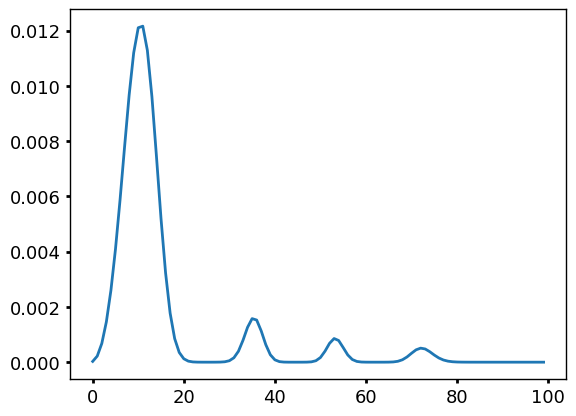

In [56]:
calculator_nu1 = SphericalInvariants(**hypers_tmp)
ground_truth = calculator_nu1.transform(frames_dimer).get_features(calculator_nu1)[::len(frames_dimer[0])]

plt.plot(ground_truth[0])
plt.show()
plt.close()

cutoff 3.9
cutoff 6.9
cutoff 9.9


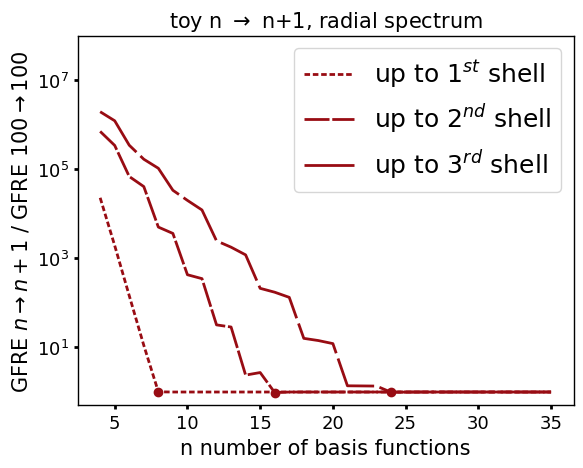

In [57]:
max_angular = 0
linestyles = [(0, (2, 1)), (0, (9, 1)), (0, (20, 2))]
converged_nb_bf_toy = [8, 16, 24]
for i in range(len(peaks_toy)):
    cutoff = round(peaks_toy[i]+0.3*3, 2)
    print("cutoff", cutoff)
    gfre_nmax_toy = [gfre_rs_conv['toy'][str(cutoff)][str(gaussian_sigma_constant)][str(max_angular)][str(max_radial)] for max_radial in max_radials]
    ref = np.mean(gfre_rs_selfconv['toy'][str(cutoff)][str(gaussian_sigma_constant)][str(max_angular)][str(100)])

    # errorbar not needed because so small
    #plt.errorbar(max_radials,
    #             np.mean(gfre_nmax_toy, axis=1),
    #             yerr=np.var(gfre_nmax_toy, axis=1),
    #             label=f'$r_c={cutoff}$', color='C0', linestyle=linestyles[i])
    plt.plot(max_radials,
             np.mean(gfre_nmax_toy, axis=1)/ref,
             label="up to "+labels[i]+' shell', color=red, linestyle=linestyles[i])
    #print(np.mean(gfre_nmax_toy, axis=1))
    plt.scatter(converged_nb_bf_toy[i:i+1], np.mean(gfre_nmax_toy, axis=1)[converged_nb_bf_toy[i]-np.min(max_radials)]/ref, color=red)
plt.yscale('log')
plt.xticks(np.arange(5,36,5))
plt.title('toy n $\\rightarrow$ n+1, radial spectrum', usetex=False)
plt.ylabel('GFRE $n \\rightarrow n+1$ / GFRE $100 \\rightarrow 100$ ')
plt.xlabel('n number of basis functions')
plt.ylim(0.5,1e8)
plt.legend()
plt.savefig('gfre_radial_basis_function_convergence-rs-toy.png')
plt.savefig('gfre_radial_basis_function_convergence-rs-toy.svg')
plt.show()



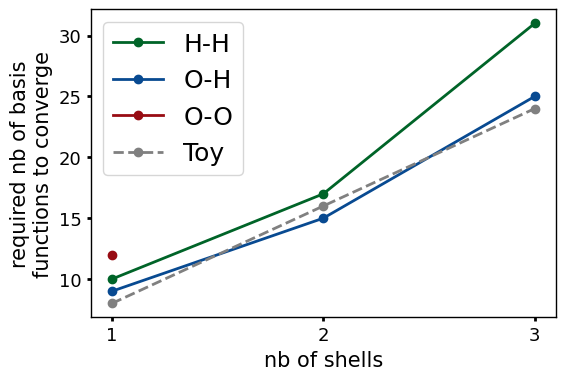

In [58]:
plt.figure(figsize=(6,4))
# we consider the basis converged for this threshold
plt.plot(np.arange(1, len(peaks_HH)+1), converged_nb_bf_HH, marker='o', label='H-H', color=green)
plt.plot(np.arange(1, len(peaks_OH)+1), converged_nb_bf_OH, marker='o', label='O-H', color=blue)
plt.plot(np.arange(1, len(peaks_OO)+1), converged_nb_bf_OO, marker='o', label='O-O', color=red)
plt.plot(np.arange(1, len(peaks_toy)+1), converged_nb_bf_toy, marker='o', label='Toy', color='gray', linestyle='dashed')

#plt.title('nmax convergence wrt ring number')
plt.xticks([1,2,3])
plt.ylabel('required nb of basis\nfunctions to converge')
plt.xlabel('nb of shells')
plt.legend()
filename = 'gfre-rs-rbf_convergence_wrt_atomic_rings'
#plt.savefig(filename+'.svg')
#plt.savefig(filename+'.png')
plt.show()

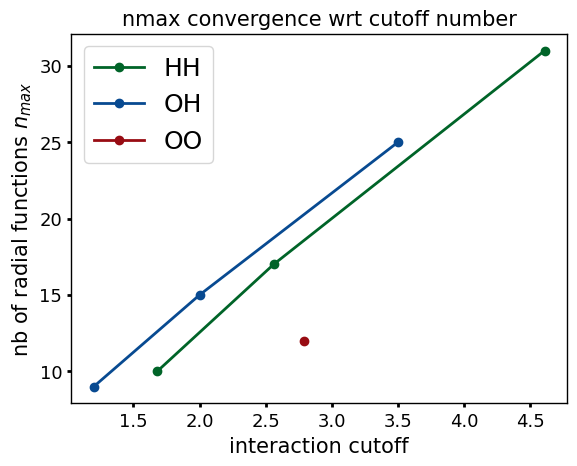

In [59]:
# we consider the basis converged for this threshold
rings_range_OO
plt.plot(np.array(rings_range_HH)[:, 1], converged_nb_bf_HH, marker='o', label='HH', color=green)

plt.plot(np.array(rings_range_OH)[:, 1], converged_nb_bf_OH, marker='o', label='OH', color=blue)
plt.plot(np.array(rings_range_OO)[:, 1], converged_nb_bf_OO, marker='o', label='OO', color=red)


plt.title('nmax convergence wrt cutoff number')
plt.ylabel('nb of radial functions $n_{max}$')
plt.xlabel('interaction cutoff')
plt.legend()
filename = 'gfre-rs-rbf_convergence_wrt_cutoff'
plt.savefig(filename+'.svg')
plt.savefig(filename+'.png')
plt.show()

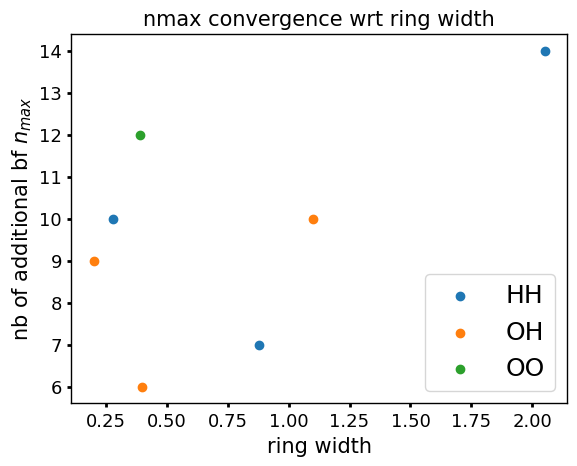

In [60]:
# we consider the basis converged for this threshold
plt.scatter(np.diff(rings_width_HH).reshape(-1), np.diff(np.hstack([0, converged_nb_bf_HH])), marker='o', label='HH')
plt.scatter(np.diff(rings_width_OH).reshape(-1), np.diff(np.hstack([0, converged_nb_bf_OH])), marker='o', label='OH')
plt.scatter(np.diff(rings_width_OO).reshape(-1), np.diff(np.hstack([0, converged_nb_bf_OO])), marker='o', label='OO')

plt.title('nmax convergence wrt ring width')
plt.ylabel('nb of additional bf $n_{max}$')
plt.xlabel('ring width')
plt.legend()
plt.show()

### Saving results

In [61]:
np.save(GFRE_RS_CONV_ABSPATH, gfre_rs_conv)

In [62]:
np.save(GFRE_RS_SELFCONV_ABSPATH, gfre_rs_selfconv)

### Cleanup tmp directory

In [63]:
if 'TMP_DIR' in globals():
    TMP_DIR.cleanup()